# Análisis de datos Experimento 1
Con 10% de hábitat en el paisaje, 10 niveles de intensificación y 100 comunidades.

In [1]:
import numpy as np
import seaborn, math, os
from matplotlib import pyplot as plt
import scipy.stats as stats

C:\Anaconda\envs\py35\lib\site-packages\matplotlib\__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
%matplotlib notebook
plt.style.use('seaborn-whitegrid')
#plt.style.use('grayscale')
seaborn.set_palette("deep", color_codes=True)

C:\Anaconda\envs\py35\lib\site-packages\matplotlib\__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
np.set_printoptions(precision=3, suppress=True)

In [4]:
%run medidas_biodiversidad.py

## Funciones para leer datos, etc

In [5]:
def leer_datos(het):
    files = os.listdir("./datos/exp1")
    files.sort()
    files = list(filter(lambda x: x[6] == het, files))
    
    datos = [np.load("./datos/exp1/" + file) for file in files]
    comunidad = [file[9:12] for file in files]
    
    return datos, comunidad

In [6]:
def calcular_medida(medida, datos, paisajes, bio_min = 5.):
    medidas = np.zeros((100, 10))
    for comunidad in range(len(datos)):
        for intensificacion in range(len(datos[0])):
            medidas[comunidad, intensificacion] = medida(
                                                    datos[comunidad][intensificacion], 
                                                    paisajes[intensificacion],
                                                    t=-2, biomasa_min = bio_min)
    return medidas

In [7]:
def calcular_riqueza(datos, paisajes, bio_min = 5.):
    riquezas = np.zeros((100, 10))
    biomasas = np.zeros((100, 10))

    for comunidad in range(len(datos)):
        for intensificacion in range(len(datos[0])):
            biomasas[comunidad, intensificacion], riquezas[comunidad, intensificacion] = riqueza_agricola(
                                                    datos[comunidad][intensificacion], 
                                                    paisajes[intensificacion],
                                                    t=-2, biomasa_min = bio_min)
    return biomasas, riquezas

In [8]:
def calcular_riquezatotal(datos, bio_min = 5.):
    riquezas = np.zeros((100, 10))
    for comunidad in range(len(datos)):
        for intensificacion in range(len(datos[0])):
            riquezas[comunidad, intensificacion] = riqueza_paisaje(
                                                    datos[comunidad][intensificacion],
                                                    t=-2, biomasa_min = bio_min)[1]
    return riquezas

In [9]:
def calcular_promedio(riquezas):
    """Recibe datos de riqueza.
    """
    promedios = np.zeros(10)
    std = np.zeros(10)
    for i in range(10):
        promedios[i] = np.mean(riquezas[riquezas[:, 0]>=0, i]) #Por qué >=???
        std[i] = np.std(riquezas[:, i])
    return promedios, std

def calcular_prueba(datos, paisajes, bio_min = 5.):
    riquezas = np.zeros((100, 10))
    for comunidad in range(len(datos)):
        for intensificacion in range(len(datos[0])):
            riquezas[comunidad, intensificacion] = medida_prueba(
                                                    datos[comunidad][intensificacion], 
                                                    paisajes[intensificacion],
                                                    t=-2, biomasa_min = bio_min)
    return riquezas

## Leer datos, calcular promedios, sd

In [10]:
paisajes = [None] * 5
for het in range(5):
    paisajes[het] = np.load("paisajes_h{}.npy".format(het))

In [11]:
datos = [None] * 5
riquezas = [None] * 5
biomasas = [None] * 5
riquezas_mean = [None] * 5
riquezas_sd = [None] * 5
biomasas_mean = [None] * 5
biomasas_sd = [None] * 5

sw = [None] * 5
sw_mean = [None] * 5
sw_sd = [None] * 5


prueba = [None] * 5
prueba_mean = [None] * 5
prueba_sd = [None] * 5

for het in range(5):
    datos[het] = leer_datos(str(het))[0]
    
    biomasas[het], riquezas[het] = calcular_riqueza(datos[het], paisajes[het], bio_min = 10)
    
    #normalizar riquezas: (pensar al respecto)
    #for i in range(len(riquezas[het])):
    #    riquezas[het][i] = riquezas[het][i] / riquezas[het][i, 0] 
    
    riquezas_mean[het], riquezas_sd[het] = calcular_promedio(riquezas[het])
    
    sw[het] = calcular_medida(shannon_wiener, datos[het], paisajes[het], bio_min = 10)
    sw_mean[het], sw_sd[het]  = calcular_promedio(sw[het])
    
    prueba[het] = calcular_medida(medida_prueba,  datos[het], paisajes[het], bio_min = 10)
    prueba_mean[het], prueba_sd[het] = calcular_promedio(prueba[het])
    
    #normalizar biomasas:
    #for i in range(len(biomasas[het])):
    #    biomasas[het][i] = biomasas[het][i] / biomasas[het][i, 0]  
    
    biomasas_mean[het], biomasas_sd[het] = calcular_promedio(biomasas[het])    

prueba = [None] * 5
prueba_mean = [None] * 5
prueba_sd = [None] * 5

for het in range(5):
    prueba[het] = calcular_medida(medida_prueba, datos[het], paisajes[het], bio_min = 10)
    prueba_mean[het], prueba_sd[het] = calcular_promedio(prueba[het])  

In [12]:
riquezatotal = [None] * 5
riquezatotal_mean = [None] * 5
riquezatotal_sd = [None] * 5

for het in range(5):
    riquezatotal[het] = calcular_riquezatotal(datos[het], bio_min = 10)
    riquezatotal_mean[het], riquezatotal_sd[het] = calcular_promedio(riquezatotal[het])  

## Graficar

In [13]:
def graficar(medida, promedios, sd):
    """Graficar promedios de una medida de biodiversidad con curva ajustada ponderada
    """
    %matplotlib inline
    #seaborn.set_palette("deep", color_codes=True)

    y = [None] * 5
    res = [None] * 5
    p = [None] * 5
    r2 = [None] * 5

    x = np.linspace(0, 9, 100)
    xdata = np.array(range(10))
    xlabels = np.array(range(10)) * 10 

    puntos = ["o", "p", "d", "v", "s"]
    colors = ["b", 'g', 'r', 'purple', 'y']

    for het in range(5):
        res[het] = np.polyfit(xdata, promedios[het], 2, w=sd[het])
        p[het] = np.poly1d(res[het])
        r2[het] = 1 - ((np.sum((p[het](range(10)) - promedios[het])**2)) / (np.sum((promedios[het] - np.mean(promedios[het]))**2)))

    fig = plt.figure(figsize=(10, 7), dpi = 50)

    for het in range(0, 5):
        y[het] = p[het](x)
        plt.plot(xdata, promedios[het], 'o', color= colors[het]) #data points
        plt.plot(x, y[het], lw = 3, color= colors[het], label='{} \n $y = {:+.3f} x^2 {:+.3f} x {:+.3f}$ \n $R^2={:.4f}$ '.format(
                                het, float(p[het][2]), float(p[het][1]), float(p[het][0]), float(r2[het]))) #fit
        #plt.errorbar(xdata, promedios[het], yerr=sd[het], fmt=puntos[het], color = colors[het])

    plt.ylim(-0.05)
    plt.xlim(-0.1, 9.1)
    plt.xticks(xdata, xlabels)
    plt.xlabel("% intensificación", size = 15)
    plt.ylabel(medida, size = 15)
    #plt.yscale("log")
    plt.title("Pérdida de {} en paisajes con distinta heterogeneidad".format(medida), size = 15)

    plt.legend(loc='center left', fontsize = "large", title="heterogeneidad", bbox_to_anchor=(1, 0.5))

    plt.show()

In [14]:
def graficar_violin(medida, datos, promedios, sd):
    """Graficar datos con violin plot
    """
    %matplotlib inline
    #seaborn.set_palette("deep", color_codes=True)

    y = [None] * 5
    res = [None] * 5
    p = [None] * 5
    r2 = [None] * 5

    x = np.linspace(0, 9, 100)
    xdata = np.array(range(10))
    xlabels = np.array(range(10)) * 10 

    puntos = ["o", "p", "d", "v", "s"]
    colors = ["b", 'g', 'r', 'purple', 'y']

    for het in [4]:
        res[het] = np.polyfit(xdata, promedios[het], 2, w=sd[het])
        p[het] = np.poly1d(res[het])
        r2[het] = 1 - ((np.sum((p[het](range(10)) - promedios[het])**2)) / (np.sum((promedios[het] - np.mean(promedios[het]))**2)))
    
    fig = plt.figure(figsize=(10, 7), dpi = 100)

    for het in [4]:
            y[het] = p[het](x)
            plt.plot(x, y[het], lw = 3, color= colors[het], label='{} \n $y = {:+.3f} x^2 {:+.3f} x {:+.3f}$ \n $R^2={:.4f}$ '.format(
                                het, float(p[het][2]), float(p[het][1]), float(p[het][0]), float(r2[het]))) #fit
            plt.violinplot(datos[het, :, :], xdata, showmedians=True, showextrema=False, showmeans=True) #data points

    plt.ylim(-0.05)
    plt.xlim(-0.1, 9.1)
    plt.xticks(xdata, xlabels)
    plt.xlabel("% intensificación", size = 15)
    plt.ylabel(medida, size = 15)
    #plt.yscale("log")
    plt.title("Pérdida de {} en paisajes con distinta heterogeneidad".format(medida), size = 15)

    plt.legend(loc='center left', fontsize = "large", title="heterogeneidad", bbox_to_anchor=(1, 0.5))

    plt.show()

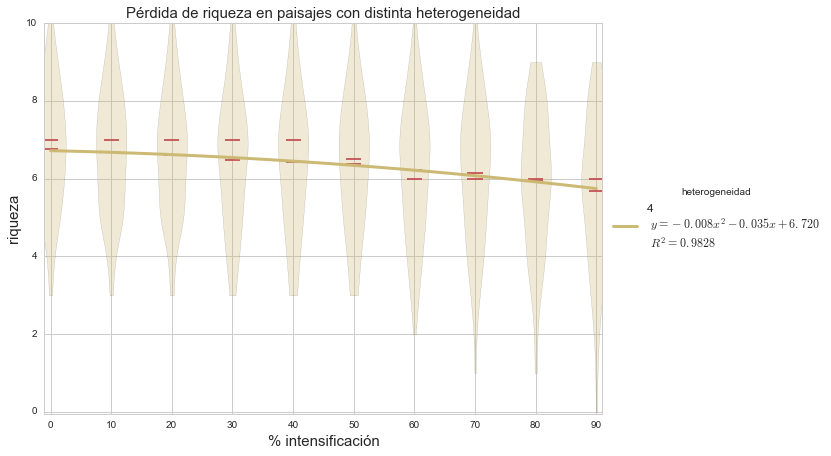

In [15]:
graficar_violin('riqueza', np.array(riquezas), riquezas_mean, riquezas_sd)

### Riqueza

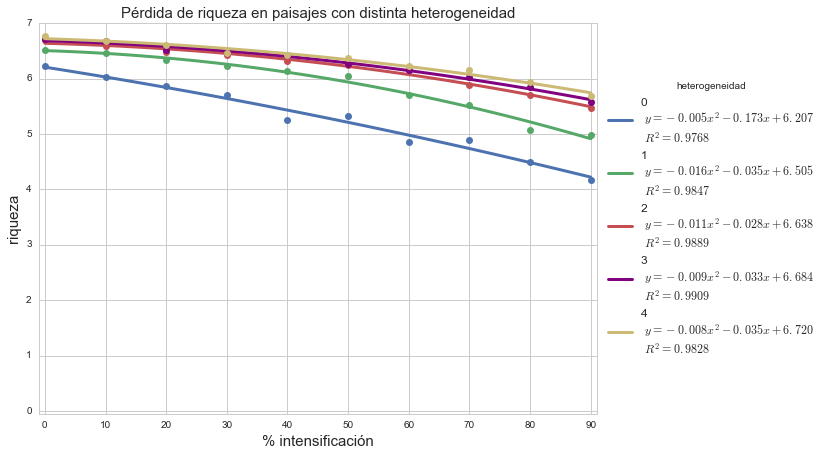

In [16]:
graficar('riqueza', riquezas_mean, riquezas_sd)

1. 
Richness declines as a concave down curve with decreasing landscape quality, at all heterogeneity levels.
=> Richness is robust in high quality agricultural landscapes.


2. 
Richness is higher in high heterogeneity landscapes than in low heterogeneity landscapes. 
=> There is a significant difference in richness between landscapes at the two extremes of heterogeneity.  
=> Spatial distribution of habitat patches becomes important at/in/on low quality landscapes.

3. 
Our results were sensitive to the species extinction threshold.
However, richness preserved a concave down curve at increasing orders of magnitude (from 0.0001 to 100), even if there was not a significant difference between heterogeneity levels at some of those values. We chose the maximum value for which average richness at the highest quality landscape was closest to that of the control experiment (//missing!), which does not consider spatial dynamics.

Reading "Using optimization methods...". The authors discuss:
"...in real-world landscapes, a combination of both sharing and sparing strategies is likely needed... Our results can thus be seen as a theoretical example supporting this assertion."

How do we contextualize our results within this argument?? ie basically we are reframing the sharing-sparing debate to account for the compound effect of landscape quality and heterogeneity. Another important property of our model is that we adopt a landscape perspective instead of focusing on a per-patch perspective?? 

Methods
We simulate landscapes with a two-dimensional lattice of 10 by 10 cells with periodic boundary. Each cell represents one patch of either habitat, biodiversity friendly / high quality / low intensity agriculture or biodiversity unfriendly / low quality / high intensity agriculture, and may be occupied by a community, that is, by interacting populations of multiple species. We define the quality of the landscape as the proportion of biodiversity friendly patches. Thus we model the decrease of landscape quality by increasing the proportion of biodiversity unfriendly patches. (//clarify difference between cells / patches).

Discussion
We adapt the model derived by González et al. to study the combined effect of landscape quality and heterogeneity on species richness. 

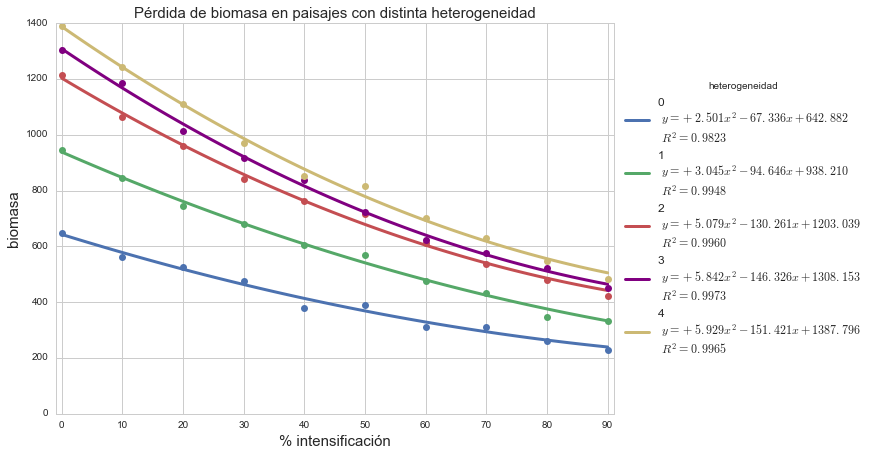

In [17]:
graficar('biomasa', biomasas_mean, biomasas_sd)

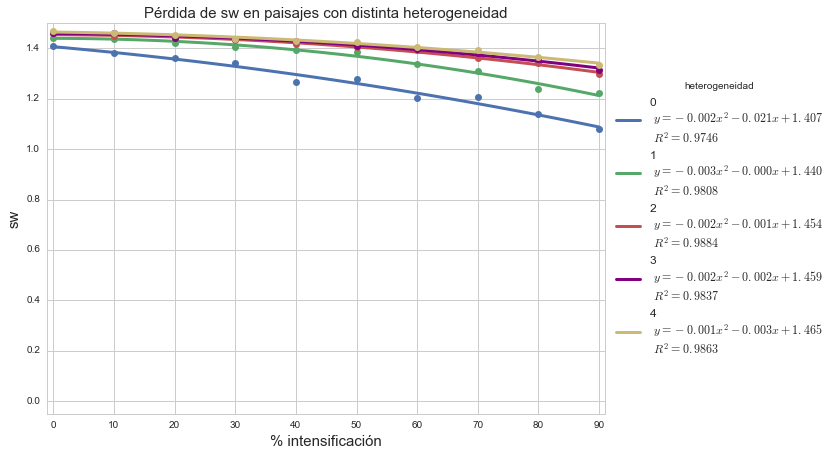

In [18]:
graficar('sw', sw_mean, sw_sd)

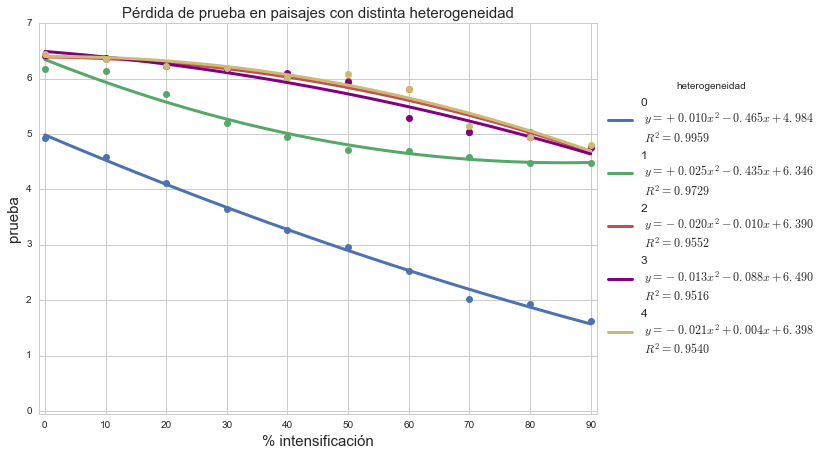

In [19]:
graficar('prueba', prueba_mean, prueba_sd)

1. 
We also explored how impossing a minimum spatial distribution of species as a threshold for extinction changed richness.
In low heterogeneity landscapes, richness declines as a concave up curve with decreasing landscape quality; in contrast, richness follows a concave down curve in high heterogeneity landscapes. 
Richness is robust at high quality landscapes only when heterogeneity is also high. But in low heterogeneity landscapes, richness declines drastically as quality decreases. 
In this case, spatial distribution of habitat patches is important at intermediate levels of landscape quality.

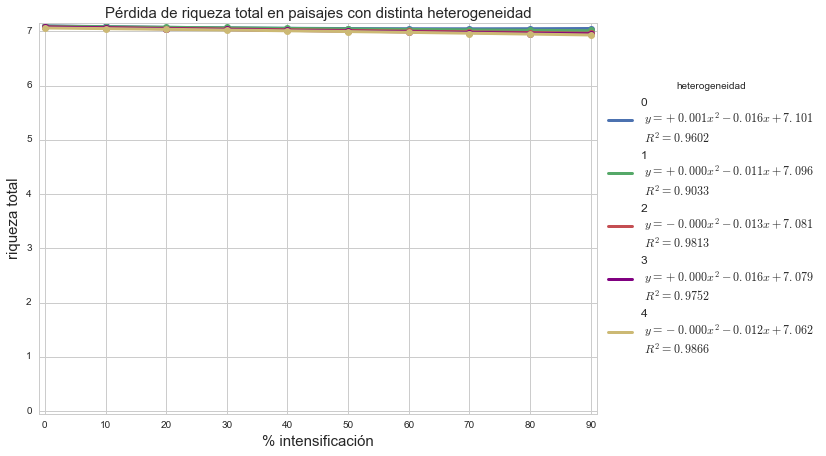

In [21]:
graficar('riqueza total', riquezatotal_mean, riquezatotal_sd)

In [51]:
riquezatotal_mean

[array([ 7.1 ,  7.09,  7.07,  7.07,  7.05,  7.05,  7.05,  7.05,  7.05,  7.05]),
 array([ 7.09,  7.08,  7.08,  7.08,  7.06,  7.04,  7.02,  7.02,  7.02,  7.02]),
 array([ 7.08,  7.07,  7.05,  7.05,  7.03,  7.01,  7.01,  6.99,  6.97,  6.97]),
 array([ 7.08,  7.06,  7.04,  7.04,  7.03,  7.  ,  6.99,  6.97,  6.96,  6.96]),
 array([ 7.06,  7.05,  7.04,  7.03,  7.01,  6.99,  6.98,  6.96,  6.96,  6.93])]

Los puntos más fuertes del modelo son: uso de redes; calidad del manejo, no sólo pérdida de hábitat; ubicarlo en un contexto de conservación. 

Las debilidades: no utilizamos un algoritmo para crear el paisaje, por lo que no podemos controlar parámetros de % hábitat o heterogeneidad/fragmentación; la escala espacial / temporal; 'identidad' de los nodos (M sugiere que para un trabajo posterior se podrían asignar diferentes parámetros de dispersión dependiendo del nivel trófico -- para esto, revisar artículo que compara la supervivencia de diferentes perfiles de especies, que de hecho (creo que es ese) también considera tres tipos de parche (¿cómo miden la calidad de los parches?)).

Preguntas: ¿dependen estas curvas de la cantidad de hábitat? Hacer simulaciones con 70% de hábitat, aunque pensar sobre cómo medir la heterogeneidad. Y revisar ese artículo que discute los niveles de fragmentación donde importa más el manejo. No debemos saturar el texto con información redundante, así que creo que sería conveniente centrarnos en paisajes altamente fragmentados. Los resultados con mayores % hábitat quizá mencionarlo como otra prueba de robustez?? 
También habíamos considerado hacer simulaciones para comparar cómo decae la riqueza conforme se pierde el hábitat, aquí sólo habría dos tipos de parche: hábitat-no hábitat y el objetivo sería comparar nuestro modelo con alguno de los otros, en especial con el que modela la pérdida de hábitat + heterogeneidad en Brasil; replicar resultados de otros es una forma de validación del modelo... pensar al respecto. También: considerar medidas de biodiversidad que consideren la distribución espacial. ¿Cómo argumentar la continuación? 

Para la próxima semana: análisis de sensibilidad de umbral - los patrones que se observan en las curvas (con nivel bio_min = 10 -- parece que es el que usaré) surgen conforme aumenta ese umbral y se mantienen en el rango... por lo menos hasta bio_min = 15. Probar con crecientes órdenes de magnitud. 

¿Qué otros parámetros podrían ser sensibles en el modelo? O que es lo mismo, ¿cuáles son nuestras suposiciones más delicadas que no tienen un sustento biológico/ecológico, que sólo son suposiciones 'numéricas'? Esto es diferente a las debilidades del modelo. Umbral de biomasa min; cantidad de iteraciones entre migración-muerte; las medidas de riqueza se toman como la mediana de la última iteración (se tendría que justificar por qué no el promedio...); la medida de heterogeneidad del paisaje y que fueron creados manualmente; las pruebas estadísticas son básicas y ahora que ya no estamos probando directamente las dos hipótesis no hay una razón para ajustar polinomio cuadrático excepto por continuación del trabajo ya publicado. 

Revisar en el artículo más reciente: redes solo surgen a nivel del paisaje. 

Dónde se ubican los paisajes que se asocian a una u otra estrategia de conservación --> aquí es donde incluiríamos el debate sharing-sparing

¿Cómo concluir? Podríamos sugerir comparar comunidades: ¿una misma comunidad cambia la forma en que decae su riqueza dependiendo del nivel de heterogeneidad del paisaje donde se encuentre? Quizá la mayoría de las comunidades mantienen la forma de la curva, pero con riqueza decreciente; quizá existan comunidades más sensibles que presenten una transición de decaimiento cóncavo hacia arriba -> cóncavo hacia abajo; quizá la mayoría presentan un decaimiento sigmoidal y cambia el umbral de intensificación en el que decaen abruptamente. 

Recordar: por qué interesan patrones generales - difícil encontrar datos para todas las regiones donde también se presenta este fenómeno, tanto de uso de suelo como de las comunidades que los habitan. Falta una referencia acerca de que actividades agrícolas producen distintos patrones de heterogeneidad y sería valioso citar una referencia local. El enfoque teórico nos permite comparar fácilmente diferentes medidas de biodiversidad: es necesario considerar la distribución geográfica.

Fin.

In [45]:
biomasas

array([[[  788.136,   683.814,   638.876, ...,   379.805,   319.082,
           276.898],
        [  989.078,   858.197,   801.809, ...,   476.747,   400.546,
           347.608],
        [  247.784,   214.976,   200.847, ...,   119.381,   100.29 ,
            87.027],
        ..., 
        [  913.069,   792.233,   740.178, ...,   440.075,   369.728,
           320.858],
        [  720.106,   624.816,   583.763, ...,   347.097,   291.618,
           253.076],
        [  380.201,   329.934,   308.266, ...,   183.379,   154.091,
           133.742]],

       [[ 1147.848,  1026.757,   907.273, ...,   527.116,   423.697,
           404.573],
        [ 1441.511,  1289.534,  1139.589, ...,   662.246,   532.379,
           508.358],
        [  360.615,   322.545,   284.977, ...,   165.52 ,   133.024,
           127.018],
        ..., 
        [ 1330.367,  1190.062,  1051.633, ...,   611.05 ,   491.185,
           469.018],
        [ 1049.48 ,   938.832,   829.663, ...,   482.136,   387.587,
 

## Anova

# shape: [het, comunidades, intensificación]
riquezas = np.array(riquezas)
biomasas = np.array(biomasas)
pruebas = np.array(prueba)

In [47]:
# contar cuántas comunidades no tuvieron cambios en niveles de intensificación
"""Esto es importante y también depende del umbral de biomasa min
¿Qué tan relevante es que en algunas / varias de las comunidades no cambié la riqueza conforme decae la intensificación.
Este fue el criterio para considerar que las dinámicas estaban acopladas en el modelo anterior...
"""
count = 0
for het in [4]:
    for c in range(100):
        if pruebas[het, c, 0] == pruebas[het, c, 9]:
            print(c)
            count += 1
count

4
6
13
28
32
37
38
47
48
52
67
73
75
80
83
86
88
95
97


19

In [136]:
#
i = 6
stats.kruskal(np.array(prueba)[4, :, i],
              np.array(prueba)[1, :, i], equal_var=False)

KruskalResult(statistic=13.217125869498098, pvalue=0.00027740267778680861)

¿En qué niveles de intensificación hay una diferencia significativa entre dos niveles de heterogeneidad? Para riqueza
Dos pruebas estadísticas que no asumen varianzas iguales (aunque para empezar se debería probar que los datos se distribuyen de forma normal):

* Hay diferencia entre nivel 4 y 0 en todos los niveles de heterogeneidad.
* Entre nivel 4 y 3: no hay diferencia
* Entre nivel 4 y 2: no hay diferencia
* Entre nivel 4 y 1: diferencia en niveles 7-9
* Entre nivel 3 y 2: no hay diferencia
* Entre nivel 3 y 1: diferencia entre nivel 8 y 9
* Entre nivel 3 y 0: diferencia en todos los niveles, excepto en nivel 0 con prueba kruskal
* Entre nivel 2 y 1: diferencia entre nivel 8 y 9 (con prueba ttest) y sólo en nivel 8 con prueba kruskal
* Entre nivel 2 y 0: diferencia en todos los niveles, excepto en nivel 0 con prueba kruskal
* Entre nivel 1 y 0: diferencia de nivel 3 a 9 con prueba ttest, diferencia de nivel 4 a 9 con prueba kruskal

In [145]:
# ¿En qué niveles de intensificación hay una diferencia significativa entre dos niveles de heterogeneidad?
for n in range(10):
    ttest = stats.ttest_ind(np.array(biomasas)[3, :, n],
                            np.array(biomasas)[2, :, n], equal_var=False)
    print("intensificacion {}:  ".format(n), ttest)

intensificacion 0:   Ttest_indResult(statistic=0.66317419005635814, pvalue=0.50799440156475562)
intensificacion 1:   Ttest_indResult(statistic=0.99250454814184852, pvalue=0.32217699139456768)
intensificacion 2:   Ttest_indResult(statistic=0.51436536969383329, pvalue=0.60757204139352872)
intensificacion 3:   Ttest_indResult(statistic=0.79300735142056888, pvalue=0.42872988872644546)
intensificacion 4:   Ttest_indResult(statistic=0.84832898322360883, pvalue=0.39728799067799481)
intensificacion 5:   Ttest_indResult(statistic=0.093870850455131813, pvalue=0.92530668305351904)
intensificacion 6:   Ttest_indResult(statistic=0.20623699035115786, pvalue=0.83681782059920706)
intensificacion 7:   Ttest_indResult(statistic=0.6552701152674022, pvalue=0.51305838652023406)
intensificacion 8:   Ttest_indResult(statistic=0.82823784626518082, pvalue=0.40854123905698025)
intensificacion 9:   Ttest_indResult(statistic=0.571069138687332, pvalue=0.56860294180223681)


In [131]:
# ¿En qué niveles de intensificación hay una diferencia significativa entre dos niveles de heterogeneidad?
# Another way to perform test without assuming equal variance
for n in range(10):
    kruskal = stats.kruskal(np.array(riquezas)[1, :, n],
                            np.array(riquezas)[4, :, n])
    print("intensificacion {}:  ".format(n), kruskal)

intensificacion 0:   KruskalResult(statistic=1.0402351294341139, pvalue=0.30776679333340407)
intensificacion 1:   KruskalResult(statistic=0.68382069738087403, pvalue=0.40827417731077453)
intensificacion 2:   KruskalResult(statistic=1.1916218180972573, pvalue=0.2750026603226412)
intensificacion 3:   KruskalResult(statistic=0.94683386900000666, pvalue=0.33052652020087714)
intensificacion 4:   KruskalResult(statistic=1.0312957889467294, pvalue=0.30985451833365507)
intensificacion 5:   KruskalResult(statistic=1.4545427741139734, pvalue=0.22780042243915533)
intensificacion 6:   KruskalResult(statistic=3.431952667099214, pvalue=0.063946452420794303)
intensificacion 7:   KruskalResult(statistic=4.8655645932241551, pvalue=0.027397832390299574)
intensificacion 8:   KruskalResult(statistic=8.7190843606010855, pvalue=0.0031489615296870239)
intensificacion 9:   KruskalResult(statistic=5.7823176533802156, pvalue=0.016188182038853381)


In [24]:
het = 0
ttest2 = stats.f_oneway(np.array(riquezas)[het, :, 0],
                         np.array(riquezas)[het, :, 1],
                         np.array(riquezas)[het, :, 2],
                         np.array(riquezas)[het, :, 3],
                         np.array(riquezas)[het, :, 4],
                         np.array(riquezas)[het, :, 5],
                         np.array(riquezas)[het, :, 6],
                         np.array(riquezas)[het, :, 7],
                         np.array(riquezas)[het, :, 8],
                         np.array(riquezas)[het, :, 9])
ttest2

F_onewayResult(statistic=12.082064979071156, pvalue=3.0307911836373869e-18)

In [34]:
#not assuming equal variance
het = 3
ttest2 = stats.kruskal(np.array(riquezas)[het, :, 0],
                         np.array(riquezas)[het, :, 1],
                         np.array(riquezas)[het, :, 2],
                         np.array(riquezas)[het, :, 3],
                         np.array(riquezas)[het, :, 4],
                         np.array(riquezas)[het, :, 5],
                         np.array(riquezas)[het, :, 6],
                         np.array(riquezas)[het, :, 7],
                         np.array(riquezas)[het, :, 8],
                         np.array(riquezas)[het, :, 9])
ttest2

KruskalResult(statistic=30.202227803862929, pvalue=0.00040527664115303771)

In [48]:
?stats.kruskal

In [95]:
print(plt.style.available)


['seaborn-notebook', 'seaborn-dark-palette', 'bmh', 'seaborn-white', 'seaborn-darkgrid', 'seaborn-ticks', 'seaborn-talk', 'seaborn-poster', 'seaborn-pastel', 'ggplot', 'seaborn-dark', 'seaborn-deep', 'seaborn-bright', 'seaborn-whitegrid', 'seaborn-colorblind', 'fivethirtyeight', 'grayscale', 'seaborn-muted', 'dark_background', 'classic', 'seaborn-paper']
